## Introduction

## Seeds

## Zaar Optimize Algorithm

## Sentinel Native Algorithm

In [12]:
import os
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystac_client
from scipy import ndimage as ndi
from distributed import LocalCluster
from pyproj import Transformer

In [ ]:
cluster = LocalCluster(processes=False)
client = cluster.get_client()
cluster

C:\Users\justi\AppData\Roaming\Python\Python314\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51279 instead
  warnings.warn(


LocalCluster(6a42c0fa, 'inproc://10.67.42.116/2716/9', workers=1, threads=16, memory=31.26 GiB)

2025-12-16 15:03:36,939 - distributed.scheduler - WARNING - Worker failed to heartbeat for 2701s; removing: <WorkerState 'inproc://10.67.42.116/2716/12', name: 0, status: running, memory: 0, processing: 0>
2025-12-16 15:03:36,943 - distributed.scheduler - WARNING - Workers ['inproc://10.67.42.116/2716/12'] do not use a nanny and will be terminated without restarting them
2025-12-16 15:03:36,948 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'inproc://10.67.42.116/2716/12'.
2025-12-16 15:03:36,954 - distributed.worker - WARNING - Scheduler was unaware of this worker; shutting down.


In [14]:
# Define AOI for Iceland and convert to UTM
spatial_extent = {
    "west":  -24.65,
    "south":  63.30,
    "east":  -13.17,
    "north":  66.58,
}

# BBOX in WGS84 (for STAC search in EPSG:4326)
bbox_4326 = [
    spatial_extent["west"],
    spatial_extent["south"],
    spatial_extent["east"],
    spatial_extent["north"],
]

# Convert AOI to UTM 28N (EPSG:32628) - covers western Iceland
# Sentinel-2 data is stored in UTM zones
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32628", always_xy=True)

west_utm, south_utm = transformer.transform(
    spatial_extent["west"], spatial_extent["south"]
)
east_utm, north_utm = transformer.transform(
    spatial_extent["east"], spatial_extent["north"]
)

print("Iceland BBOX in UTM 28N (EPSG:32628):")
print(f"west_utm: {west_utm:.2f}")
print(f"south_utm: {south_utm:.2f}")
print(f"east_utm: {east_utm:.2f}")
print(f"north_utm: {north_utm:.2f}")

# Spatial slice parameters
x_slice = slice(west_utm, east_utm)
y_slice = slice(north_utm, south_utm)

Iceland BBOX in UTM 28N (EPSG:32628):
west_utm: 17595.38
south_utm: 7055428.59
east_utm: 581157.36
north_utm: 7385750.35


## STAC Search

In [15]:
# Connect to the STAC catalog
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")

# Search for Sentinel-2 L2A items - using 2 weeks for testing
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox_4326,
    datetime="2025-11-15/2025-11-30",  # 2 weeks for testing
)

# Retrieve the list of matching items
items = list(search.items())
hrefs = [item.assets["product"].href for item in items]

print(f"Found {len(items)} items")

Found 82 items


In [16]:
print(f"List of Items returned from the STAC query: {items}")
print(f"List of Zarr URLs returned from the STAC query: {hrefs}")

List of Items returned from the STAC query: [<Item id=S2B_MSIL2A_20251128T124359_N0511_R095_T28VDR_20251128T165727>, <Item id=S2B_MSIL2A_20251128T124359_N0511_R095_T28VCR_20251128T165727>, <Item id=S2B_MSIL2A_20251128T124359_N0511_R095_T27VXL_20251128T165727>, <Item id=S2B_MSIL2A_20251128T124359_N0511_R095_T27VWL_20251128T165727>, <Item id=S2B_MSIL2A_20251127T131359_N0511_R081_T27VWL_20251127T134025>, <Item id=S2B_MSIL2A_20251127T131359_N0511_R081_T27VVL_20251127T134025>, <Item id=S2B_MSIL2A_20251127T131359_N0511_R081_T27VUL_20251127T134025>, <Item id=S2B_MSIL2A_20251127T131359_N0511_R081_T26WPS_20251127T134025>, <Item id=S2B_MSIL2A_20251127T131359_N0511_R081_T26VPR_20251127T134025>, <Item id=S2B_MSIL2A_20251125T123339_N0511_R052_T28WES_20251125T131214>, <Item id=S2B_MSIL2A_20251125T123339_N0511_R052_T28WDS_20251125T131214>, <Item id=S2B_MSIL2A_20251125T123339_N0511_R052_T28VER_20251125T131214>, <Item id=S2B_MSIL2A_20251125T123339_N0511_R052_T28VDR_20251125T131214>, <Item id=S2B_MSIL2A

In [17]:
import warnings
warnings.filterwarnings("ignore", message="Engine 'eopf-zarr' loading failed")


In [23]:
def extract_time(ds):
    date_format = "%Y%m%dT%H%M%S"
    filename = ds.encoding["source"]
    date_str = os.path.basename(filename).split("_")[2]
    time = datetime.strptime(date_str, date_format)
    return ds.assign_coords(time=time)

# Load data - select only needed bands
# Note: Skipping spatial subset since Iceland spans multiple UTM zones
datacube_20 = xr.open_mfdataset(
    hrefs,
    engine="zarr",
    chunks={},
    group="/measurements/reflectance/r20m",     
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    mask_and_scale=True,
).sortby("time", ascending=True)

datacube_20 = datacube_20[["b03", "b11"]]
print(f"Datacube shape: time={len(datacube_20.time)}, y={len(datacube_20.y)}, x={len(datacube_20.x)}")
datacube_20

C:\Users\justi\AppData\Local\Temp\ipykernel_2716\13449087.py:10: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',) The recommendation is to set join explicitly for this case.
  datacube_20 = xr.open_mfdataset(
C:\Users\justi\AppData\Local\Temp\ipykernel_2716\13449087.py:10: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',) The recommendation is to set join explicitly for this case.
  datacube_20 = xr.open_mfdataset(
C:\Users\justi\AppData\Roaming\Python\Python314\site-packages\dask\array\core.py:499

Datacube shape: time=82, y=20490, x=20490


<xarray.Dataset> Size: 551GB
Dimensions:  (time: 82, y: 20490, x: 20490)
Coordinates:
  * time     (time) datetime64[ns] 656B 2025-11-15T12:32:59 ... 2025-11-28T12...
  * y        (y) float32 82kB 6.99e+06 6.99e+06 6.99e+06 ... 7.4e+06 7.4e+06
  * x        (x) float32 82kB 3e+05 3e+05 3e+05 ... 7.098e+05 7.098e+05
Data variables:
    b03      (time, y, x) float64 275GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>
    b11      (time, y, x) float64 275GB dask.array<chunksize=(1, 915, 915), meta=np.ndarray>

In [ ]:
# Load SCL (Scene Classification Layer)
scl = xr.open_mfdataset(
    hrefs,
    engine="zarr",
    chunks={},
    group="/conditions/mask/l2a_classification/r20m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    mask_and_scale=True,
).sortby("time", ascending=True)[["scl"]]

# Interpolate SCL to match datacube_20 grid and add to dataset
scl_resampled = scl.scl.interp_like(datacube_20, method="nearest")
datacube_20["scl"] = scl_resampled

# Compute to load into memory
datacube_20 = datacube_20.compute()
datacube_20

C:\Users\justi\AppData\Local\Temp\ipykernel_2716\3749475497.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',) The recommendation is to set join explicitly for this case.
  scl = xr.open_mfdataset(
C:\Users\justi\AppData\Local\Temp\ipykernel_2716\3749475497.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',) The recommendation is to set join explicitly for this case.
  scl = xr.open_mfdataset(
C:\Users\justi\AppData\Roaming\Python\Python314\site-packages\dask\array\core.py:4997: Performance

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

: 

## NDSI Calculation

Calculate the Normalized Difference Snow Index (NDSI) using Band 3 (green) and Band 11 (SWIR):

$$NDSI = \frac{B03 - B11}{B03 + B11}$$

NDSI values close to 1 indicate snow/ice, while values close to -1 indicate non-snow surfaces.

In [ ]:
def compute_ndsi(ds: xr.Dataset) -> xr.DataArray:
    """
    Compute NDSI (Normalized Difference Snow Index) from Sentinel-2 bands.
    NDSI = (B03 - B11) / (B03 + B11)
    """
    green = ds["b03"].astype("float32")
    swir = ds["b11"].astype("float32")
    
    numerator = green - swir
    denominator = green + swir
    
    ndsi = xr.where(denominator != 0, numerator / denominator, np.nan)
    ndsi.name = "NDSI"
    
    return ndsi


# Calculate NDSI
ndsi_dataset = compute_ndsi(datacube_20)
ndsi_dataset

<xarray.DataArray 'NDSI' (time: 84, y: 0, x: 0)> Size: 0B
array([], shape=(84, 0, 0), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 672B 2025-11-15T12:32:59 ... 2025-12-01T12...
  * y        (y) float32 0B 
  * x        (x) float32 0B 


<xarray.DataArray 'NDSI' (time: 84, y: 0, x: 0)> Size: 0B
array([], shape=(84, 0, 0), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 672B 2025-11-15T12:32:59 ... 2025-12-01T12...
  * y        (y) float32 0B 
  * x        (x) float32 0B

### NDSI Time Series Analysis

TypeError: No numeric data to plot.

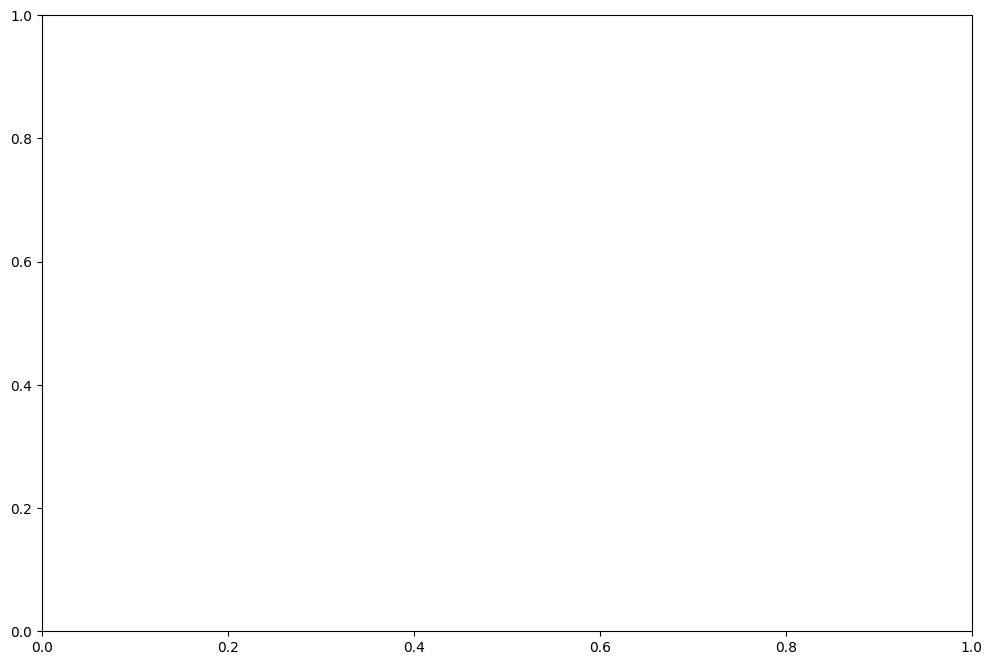

In [ ]:
# Calculate mean and std across spatial dimensions
mean_ndsi = ndsi_dataset.mean(dim=["x", "y"]).to_series()
std_ndsi = ndsi_dataset.std(dim=["x", "y"]).to_series()

# Create time series dataframe
ndsi_timeseries = pd.concat([mean_ndsi, std_ndsi], axis=1).dropna()
ndsi_timeseries.columns = ["Mean NDSI", "SD"]
ndsi_timeseries.index = pd.to_datetime(ndsi_timeseries.index)
ndsi_timeseries = ndsi_timeseries.sort_index()

# Plot time series
plt.figure(figsize=(14, 6))
plt.plot(ndsi_timeseries["Mean NDSI"], "o-", label="Mean NDSI")
plt.fill_between(
    ndsi_timeseries.index,
    ndsi_timeseries["Mean NDSI"] - ndsi_timeseries["SD"],
    ndsi_timeseries["Mean NDSI"] + ndsi_timeseries["SD"],
    color="gray",
    alpha=0.2,
    label="±1 SD"
)
plt.axhline(y=0.4, color="red", linestyle="--", label="Snow threshold (NDSI=0.4)")
plt.ylim(-1, 1)
plt.xlabel("Date")
plt.ylabel("NDSI")
plt.title("Iceland - Mean NDSI Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nNDSI Statistics:")
print(f"Mean: {ndsi_timeseries['Mean NDSI'].mean():.3f}")
print(f"Max: {ndsi_timeseries['Mean NDSI'].max():.3f}")
print(f"Min: {ndsi_timeseries['Mean NDSI'].min():.3f}")

## Algorithm Comparison

### Benchmark Zaar Optimize Algorithm

### Benchmark Sentinel Native Algorithm

### Conclusion

## Temporal Glaciar Analysis